## Studio Porjektowe 2 - [Granulated deep learning and Z-numbers in motion detection and object recognition](https://link.springer.com/article/10.1007/s00521-019-04200-1)

In [1]:
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import cv2
import math
from PIL import Image, ImageDraw
import platform

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', keras.__version__)

Python version: 3.9.12
Tensorflow version: 2.8.0
Keras version: 2.8.0


In [2]:
WINDOW_SIZE = 10
MODEL_NAME = 'ssdlite_mobilenet_v2_coco_2018_05_09'
LABELS_NAME = 'mscoco_label_map.pbtxt'
TEST_IMAGES_DIR_PATH = pathlib.Path('data')
TEST_IMAGE_PATHS = sorted(list(TEST_IMAGES_DIR_PATH.glob('*.jpg')))
TEST_IMAGE_PATHS

[PosixPath('data/elephant.jpg'),
 PosixPath('data/quad-of-four-colors.jpg'),
 PosixPath('data/simple-color-wheel.jpg')]

In [3]:
# Create cache folder.
!mkdir .tmp

mkdir: .tmp: File exists


In [4]:
# Loads the module from internet, unpacks it and initializes a Tensorflow saved model.
def load_model(model_name):
    model_url = 'http://download.tensorflow.org/models/object_detection/' + model_name + '.tar.gz'
    
    model_dir = tf.keras.utils.get_file(
        fname=model_name, 
        origin=model_url,
        untar=True,
        cache_dir=pathlib.Path('.tmp').absolute()
    )
    model = tf.saved_model.load(model_dir + '/saved_model')
    
    return model

In [5]:
saved_model = load_model(MODEL_NAME)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-04-26 12:40:35.127308: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-26 12:40:35.127719: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-04-26 12:40:35.161165: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-26 12:40:35.162054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [6]:
# Loading default model signature.
model = saved_model.signatures['serving_default']

In [7]:
def load_labels(label_map_path):

    item_id = None
    item_name = None
    items = {}
    
    with open(label_map_path, "r") as file:
        for line in file:
            line.replace(" ", "")
            if line == "item{":
                pass
            elif line == "}":
                pass
            elif "id" in line:
                item_id = int(line.split(":", 1)[1].strip())
            elif "display_name" in line:
                item_name = line.split(":", 1)[1].replace("'", "").replace('"', "").strip()

            if item_id is not None and item_name is not None:
                items[item_id] = item_name
                item_id = None
                item_name = None

    return items

In [8]:
labels = load_labels(LABELS_NAME)
labels

{1: 'person',
 2: 'bicycle',
 3: 'car',
 4: 'motorcycle',
 5: 'airplane',
 6: 'bus',
 7: 'train',
 8: 'truck',
 9: 'boat',
 10: 'traffic light',
 11: 'fire hydrant',
 13: 'stop sign',
 14: 'parking meter',
 15: 'bench',
 16: 'bird',
 17: 'cat',
 18: 'dog',
 19: 'horse',
 20: 'sheep',
 21: 'cow',
 22: 'elephant',
 23: 'bear',
 24: 'zebra',
 25: 'giraffe',
 27: 'backpack',
 28: 'umbrella',
 31: 'handbag',
 32: 'tie',
 33: 'suitcase',
 34: 'frisbee',
 35: 'skis',
 36: 'snowboard',
 37: 'sports ball',
 38: 'kite',
 39: 'baseball bat',
 40: 'baseball glove',
 41: 'skateboard',
 42: 'surfboard',
 43: 'tennis racket',
 44: 'bottle',
 46: 'wine glass',
 47: 'cup',
 48: 'fork',
 49: 'knife',
 50: 'spoon',
 51: 'bowl',
 52: 'banana',
 53: 'apple',
 54: 'sandwich',
 55: 'orange',
 56: 'broccoli',
 57: 'carrot',
 58: 'hot dog',
 59: 'pizza',
 60: 'donut',
 61: 'cake',
 62: 'chair',
 63: 'couch',
 64: 'potted plant',
 65: 'bed',
 67: 'dining table',
 70: 'toilet',
 72: 'tv',
 73: 'laptop',
 74: 'mo

In [9]:
def detect_objects_on_image(image, model):
    image = np.asarray(image)
    input_tensor = tf.convert_to_tensor(image)
    # Adding one more dimension since model expect a batch of images.
    input_tensor = input_tensor[tf.newaxis, ...]

    output_dict = model(input_tensor)

    num_detections = int(output_dict['num_detections'])
    output_dict = {
        key:value[0, :num_detections].numpy() 
        for key,value in output_dict.items()
        if key != 'num_detections'
    }
    output_dict['num_detections'] = num_detections
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
    
    return output_dict

In [10]:
def draw_detections_on_image(image, detections, labels):
    image_with_detections = image
    width, height, channels = image_with_detections.shape
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    color = (0, 255, 0)
    label_padding = 5
    
    num_detections = detections['num_detections']
    if num_detections > 0:
        for detection_index in range(num_detections):
            detection_score = detections['detection_scores'][detection_index]
            detection_box = detections['detection_boxes'][detection_index]
            detection_class = detections['detection_classes'][detection_index]
            detection_label = labels[detection_class]
            detection_label_full = detection_label + ' ' + str(math.floor(100 * detection_score)) + '%'
            
            y1 = int(width * detection_box[0])
            x1 = int(height * detection_box[1])
            y2 = int(width * detection_box[2])
            x2 = int(height * detection_box[3])
                        
            # Detection rectangle.    
            image_with_detections = cv2.rectangle(
                image_with_detections,
                (x1, y1),
                (x2, y2),
                color,
                3
            )
            
            # Label background.
            label_size = cv2.getTextSize(
                detection_label_full,
                cv2.FONT_HERSHEY_COMPLEX,
                0.7,
                2
            )
            image_with_detections = cv2.rectangle(
                image_with_detections,
                (x1, y1),
                (x1 + label_size[0][0] + 2 * label_padding, y1 + label_size[0][1] + 2 * label_padding),
                color,
                -1
            )
            
            # Label text.
            cv2.putText(
                image_with_detections,
                detection_label_full,
                (x1 + label_padding, y1 + label_padding + label_size[0][1]),
                font,
                0.7,
                (0, 0, 0),
                1,
                cv2.LINE_AA
            )
            
    return image_with_detections

2024-04-26 12:40:41.210441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


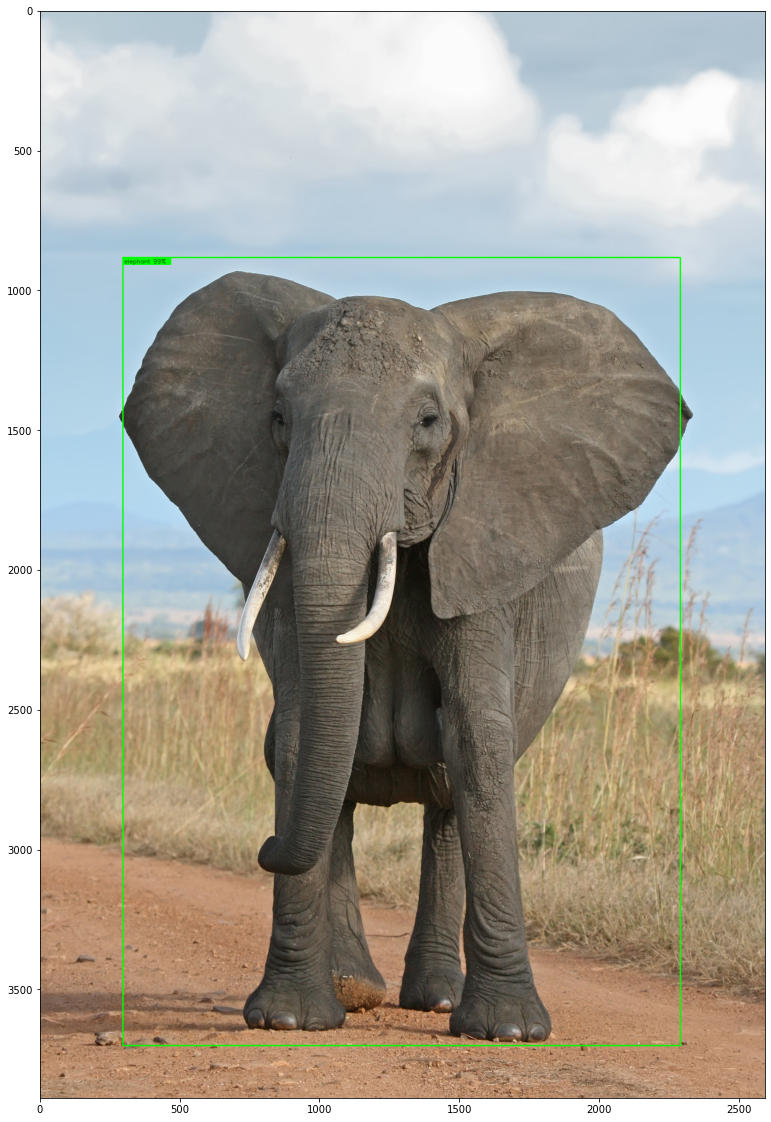

In [11]:
# Test the model on the elephant image.
image_np = np.array(Image.open('data/elephant.jpg'))
detections = detect_objects_on_image(image_np, model)
image_with_detections = draw_detections_on_image(image_np, detections, labels)
plt.figure(figsize=(20, 20))
plt.imshow(image_with_detections)

In [12]:
def plot(images, titles, subtitle=None, figsize=(8, 8)):
        
    cols = len(images)
    fig, axs = plt.subplots(1, cols, figsize=(cols * figsize[0], figsize[1]))
    if len(images) == 1:
        axs = [axs]
    if subtitle is not None:
        fig.suptitle(subtitle, fontsize=16)
    for i, (image, title) in enumerate(zip(images, titles)):
        ax = axs[i]
        ax.imshow(image)
        ax.set_title(title)
        ax.axis('off')
    plt.show()

In [13]:
def calculate_differencing(prev_f, f, vis=False):
    # Calculate the difference between the previous and the current frame.
    diff = cv2.absdiff(prev_f, f)
    if vis:
        plot([diff], ['diff'])
    return diff

#### Calculation of granulation using the simplest method. The granulated frame is the same size as the original image.

In [14]:
def granulation(image, window_size=WINDOW_SIZE, vis=False):
    height, width = image.shape[:2]
    granules = np.zeros_like(image)
    for j in range(0, height, window_size):
        for i in range(0, width, window_size):
            granule = image[j : min(j+window_size, height), i:min(i+window_size, width)]
            granules[j : min(j+window_size, height), i:min(i+window_size, width)] = np.mean(granule, axis=(0, 1))

    if vis:
        plot([image, granules], ['Original', 'Granulated'], subtitle='Granulation')
        
    return granules

#### Calculation of granulation by quad tree decomposition.

In [15]:
PADDING = 0
OUTPUT_SCALE = 1
ERROR_THRESHOLD = 5

def weighted_average(hist):
    """Returns the weighted color average and error from a hisogram of pixles"""
    total = sum(hist)
    value, error = 0, 0
    if total > 0:
        value = sum(i * x for i, x in enumerate(hist)) / total
        error = sum(x * (value - i) ** 2 for i, x in enumerate(hist)) / total
        error = error ** 0.5
    return value, error

def color_from_histogram(hist):
    """Returns the average rgb color from a given histogram of pixle color counts"""
    r, re = weighted_average(hist[:256])
    g, ge = weighted_average(hist[256:512])
    b, be = weighted_average(hist[512:768])
    e = re * 0.2989 + ge * 0.5870 + be * 0.1140
    return (int(r), int(g), int(b)), e

class QuadtreeNode(object):
    """Node for Quadtree that holds a subsection of an image and 
        information about that section"""

    def __init__(self, img, box, depth):
        self.box = box  # (left, top, right, bottom)
        self.depth = depth
        self.children = None  # tl, tr, bl, br
        self.leaf = False

        # Gets the nodes average color
        image = img.crop(box)
        self.width, self.height = image.size  # (width, height)
        hist = image.histogram()
        self.color, self.error = color_from_histogram(hist)  # (r, g, b), error
        
    def is_leaf(self):
            """Determins if a the node is a leaf"""
            return self.leaf
        
    def split(self, img):
        """Splits the given image section into four equal image boxes"""
        l, t, r, b = self.box
        lr = l + (r - l) / 2
        tb = t + (b - t) / 2
        tl = QuadtreeNode(img, (l, t, lr, tb), self.depth+1)
        tr = QuadtreeNode(img, (lr, t, r, tb), self.depth+1)
        bl = QuadtreeNode(img, (l, tb, lr, b), self.depth+1)
        br = QuadtreeNode(img, (lr, tb, r, b), self.depth+1)
        self.children = [tl, tr, bl, br]

class Quadtree(object):
    """Tree that has nodes with at most four child nodes that hold 
        sections of an image where there at most n leaf nodes where
        n is the number of pixles in the image"""

    def __init__(self, image, max_depth=1024):
        self.root = QuadtreeNode(image, image.getbbox(), 0)
        self.width, self.height = image.size
        self.max_depth = 0
        
        self._build_tree(image, self.root, max_depth)

    def _build_tree(self, image, node, max_depth):
        """Recursively adds nodes untill max_depth is reached or error is less than 5"""
        if (node.depth >= max_depth) or (node.error <= ERROR_THRESHOLD):
            if node.depth > self.max_depth:
                self.max_depth = node.depth
            node.leaf = True
            return
        
        node.split(image)
        for child in node.children:
            self._build_tree(image, child, max_depth)
        
    
    def get_leaf_nodes(self, depth):
        """Gets all the nodes on a given depth/level"""
        def get_leaf_nodes_recusion(tree, node, depth, func):
            """Recusivley gets leaf nodes based on whether a node is a leaf or the given depth is reached"""
            if node.leaf is True or node.depth == depth:
                func(node)
            elif node.children is not None:
                for child in node.children:
                    get_leaf_nodes_recusion(tree, child, depth, func)

            if depth > tree.max_depth:
                raise ValueError('A depth larger than the trees depth was given')

        leaf_nodes = []
        get_leaf_nodes_recusion(self, self.root, depth, leaf_nodes.append)
        return leaf_nodes
        

    def _create_image_from_depth(self, depth):
        """Creates a Pillow image object from a given level/depth of the tree"""
        m = OUTPUT_SCALE
        dx, dy = (PADDING, PADDING) # padding for each image section
        image = Image.new('RGB', (int(self.width * m + dx), int(self.height * m + dy)))
        draw = ImageDraw.Draw(image)
        draw.rectangle((0, 0, self.width * m + dx, self.height * m + dy), (0, 0, 0))
        granules = []
        leaf_nodes = self.get_leaf_nodes(depth)
        for node in leaf_nodes:
            l, t, r, b = node.box
            box = (l * m + dx, t * m + dy, r * m - 1, b * m - 1)
            granule_size = (int((r-l) * m), int((b-t) * m))  # Calculate the size of the granule
            granule = Image.new('RGB', granule_size, node.color)  # Create a new image with the size and color of the granule
            granule = np.array(granule)
            granules.append(granule)
            draw.rectangle(box, node.color)
        return image, granules

    def render_at_depth(self, depth=0):
        """Renders the image of a given depth/level"""
        if depth > self.max_depth:
            raise ValueError('A depth larger than the trees depth was given')

        image, granules = self._create_image_from_depth(depth)
        return image, granules
        # image.show()

    def create_gif(self, file_name, duration=1000, loop=0):
        """Creates a gif at the given filename from each level of the tree"""
        images = []
        end_product_image = self._create_image_from_depth(self.max_depth)
        for i in range(self.max_depth):
            image = self._create_image_from_depth(i)
            images.append(image)
        # Add extra final produc images to allow for seeing result longer
        for _ in range(4):
            images.append(end_product_image)
        # Save the images as a gif using Pillow
        images[0].save(
            file_name, 
            save_all=True, 
            append_images=images[1:],
            duration=duration, loop=loop)

In [33]:
def granulation_gt(frame, visual=False):
    frame_pil = Image.fromarray(frame)
    tree = Quadtree(frame_pil)
    image, granules = tree.render_at_depth(6)
    image = np.array(image)
    if visual:
        plot([frame, image], ['Original', 'Granulated'], subtitle='Granulation')
    return image, granules

Example use

/var/folders/z8/z_bh56_j7cxf4jpbcjf1hbmh0000gn/T/ipykernel_26364/3579238169.py:5: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  image, granules = np.array(image)
/var/folders/z8/z_bh56_j7cxf4jpbcjf1hbmh0000gn/T/ipykernel_26364/3579238169.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  image, granules = np.array(image)


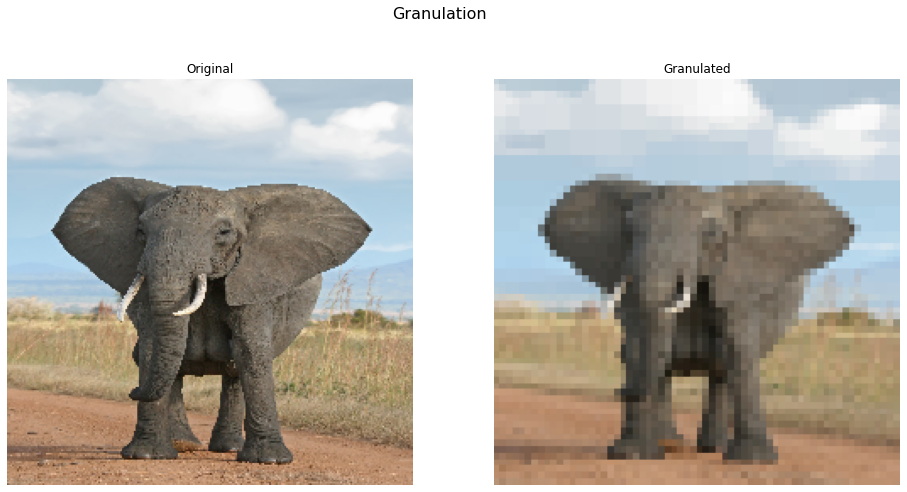

(<PIL.Image.Image image mode=RGB size=240x240>,
 [array([[[197, 211, 219],
          [197, 211, 219],
          [197, 211, 219]],
  
         [[197, 211, 219],
          [197, 211, 219],
          [197, 211, 219]],
  
         [[197, 211, 219],
          [197, 211, 219],
          [197, 211, 219]]], dtype=uint8),
  array([[[187, 204, 214],
          [187, 204, 214],
          [187, 204, 214]],
  
         [[187, 204, 214],
          [187, 204, 214],
          [187, 204, 214]],
  
         [[187, 204, 214],
          [187, 204, 214],
          [187, 204, 214]]], dtype=uint8),
  array([[[218, 224, 228],
          [218, 224, 228],
          [218, 224, 228]],
  
         [[218, 224, 228],
          [218, 224, 228],
          [218, 224, 228]],
  
         [[218, 224, 228],
          [218, 224, 228],
          [218, 224, 228]]], dtype=uint8),
  array([[[201, 213, 221],
          [201, 213, 221],
          [201, 213, 221]],
  
         [[201, 213, 221],
          [201, 213, 221],
          [2

In [17]:
img = cv2.cvtColor(cv2.imread('data/elephant.jpg'), cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (240, 240))
granulation_gt(img, visual=True)

In [18]:
image = Image.open('data/elephant.jpg').convert('RGB')
image = image.resize((image.width // 8, image.height // 8))
tree = Quadtree(image)

In [19]:
tree.render_at_depth(8)

(<PIL.Image.Image image mode=RGB size=324x486>,
 [array([[[188, 205, 215],
          [188, 205, 215]],
  
         [[188, 205, 215],
          [188, 205, 215]],
  
         [[188, 205, 215],
          [188, 205, 215]]], dtype=uint8),
  array([[[188, 205, 214],
          [188, 205, 214]],
  
         [[188, 205, 214],
          [188, 205, 214]],
  
         [[188, 205, 214],
          [188, 205, 214]]], dtype=uint8),
  array([[[210, 220, 225],
          [210, 220, 225]],
  
         [[210, 220, 225],
          [210, 220, 225]],
  
         [[210, 220, 225],
          [210, 220, 225]]], dtype=uint8),
  array([[[203, 214, 222],
          [203, 214, 222]],
  
         [[203, 214, 222],
          [203, 214, 222]],
  
         [[203, 214, 222],
          [203, 214, 222]]], dtype=uint8),
  array([[[188, 205, 214],
          [188, 205, 214],
          [188, 205, 214],
          [188, 205, 214],
          [188, 205, 214]],
  
         [[188, 205, 214],
          [188, 205, 214],
          [188,

#### Calculate the threshold by obtaining the minimum sum of ROB and RBT

In [20]:
def compute_threshold(image):
    height, width = image.shape[:2]
    width_add = 1 if width % WINDOW_SIZE != 0 else 0
    height_add = 1 if height % WINDOW_SIZE != 0 else 0
    granule_image = [[None for _ in range(width // WINDOW_SIZE+width_add)] for _ in range(height // WINDOW_SIZE+height_add)]

    for j in range(0, height, WINDOW_SIZE):
        for i in range(0, width, WINDOW_SIZE):
            granule = image[j:min(j+WINDOW_SIZE, height), i:min(i+WINDOW_SIZE, width)]
            granule_image[j//WINDOW_SIZE][i//WINDOW_SIZE] = granule

    R_OT_best = 1
    R_BT_best = 1
    T_best = 0
    print( np.mean(image), np.std(image))
    t_start = max(int(np.mean(image) - np.std(image)), 0)
    t_end = min(int(np.mean(image) + np.std(image)), 255)
    for T in range(t_start, t_end, 5):
        O_T_lower = []
        O_T_upper = []
        B_T_lower = []
        B_T_upper = []
        for row in granule_image:
            for granule in row:
                granule_greater_T = granule > T
                granule_less_T = granule < T
                if len(granule_greater_T) > 1:
                    if np.all(granule_greater_T):
                        O_T_lower.append(granule)
                    if np.any(granule_greater_T):
                        O_T_upper.append(granule)
                if len(granule_less_T):
                    if np.all(granule_less_T):
                        B_T_lower.append(granule)
                    if np.any(granule_less_T):
                        B_T_upper.append(granule)
        R_OT = 1 - len(O_T_lower) / len(O_T_upper) if len(O_T_upper) != 0 else 1
        R_BT = 1 - len(B_T_lower) / len(B_T_upper) if len(B_T_upper) != 0 else 1
        if R_OT + R_BT < R_OT_best +  R_BT_best:
            R_OT_best = R_OT
            R_BT_best = R_BT
            T_best = T
        # print('R_OT:', R_OT, '   R_BT:', R_BT, '   T:', T)
    return R_OT_best, R_BT_best, T_best

In [21]:
def compute_threshold_qtd(image, qtd_granules):
    R_OT_best = 1
    R_BT_best = 1
    T_best = 0
    print( np.mean(image), np.std(image))
    t_start = max(int(np.mean(image) - np.std(image)), 0)
    t_end = min(int(np.mean(image) + np.std(image)), 255)
    for T in range(t_start, t_end, 5):
        O_T_lower = []
        O_T_upper = []
        B_T_lower = []
        B_T_upper = []
        for granule in qtd_granules:
            granule_greater_T = granule > T
            granule_less_T = granule < T
            if len(granule_greater_T) > 1:
                if np.all(granule_greater_T):
                    O_T_lower.append(granule)
                if np.any(granule_greater_T):
                    O_T_upper.append(granule)
            if len(granule_less_T):
                if np.all(granule_less_T):
                    B_T_lower.append(granule)
                if np.any(granule_less_T):
                    B_T_upper.append(granule)
        R_OT = 1 - len(O_T_lower) / len(O_T_upper) if len(O_T_upper) != 0 else 1
        R_BT = 1 - len(B_T_lower) / len(B_T_upper) if len(B_T_upper) != 0 else 1
        if R_OT + R_BT < R_OT_best +  R_BT_best:
            R_OT_best = R_OT
            R_BT_best = R_BT
            T_best = T
        # print('R_OT:', R_OT, '   R_BT:', R_BT, '   T:', T)
    return R_OT_best, R_BT_best, T_best

#### Calculating an upper background approximation by checking if any pixel in the granule is below this threshold

In [22]:
def upper_background_approximation(gf, frame, granules_gt=None, is_gtd=False, vis=False):  
    if is_gtd:
        R_OT, R_BT, th = compute_threshold_qtd(frame, granules_gt)
    else:
        R_OT, R_BT, th = compute_threshold(frame)
    height, width = gf.shape[:2]
    print(th)
    
    ub = np.zeros_like(gf)
    
    for i in range(0, height, WINDOW_SIZE):
        for j in range(0, width, WINDOW_SIZE):
            granule = gf[i:min(i+WINDOW_SIZE, height), j:min(j+WINDOW_SIZE, width)]
            granule = cv2.cvtColor(granule, cv2.COLOR_BGR2GRAY)
            # print(np.max(granule), np.min(granule), th)
            if np.any(granule < th):
                ub[i:min(i+WINDOW_SIZE, height), j:min(j+WINDOW_SIZE, width)] = gf[i:min(i+WINDOW_SIZE, height), j:min(j+WINDOW_SIZE, width)]

    if vis:
        print("Threshold T:", th)
        plot([ub], ['Upper background approximation'])

    return ub

#### Calculating the lower background approximation by subtracting the intersection of the upper background approximation and the difference between frames

In [23]:
def granulated_background_approximation(u_b, d, frame, window_size=WINDOW_SIZE, vis=False):
    intersection = np.zeros_like(u_b)
    height, width = d.shape[:2]

    for i in range(0, height, window_size):
        for j in range(0, width, window_size):
            #change 30 working with other images
            if np.any(d[i:min(i+window_size, height), j:min(j+window_size, width)] > 0) and np.all(u_b[i:min(i+window_size, height), j:min(j+window_size, width)] != 0):

                intersection[i:min(i+window_size, height), j:min(j+window_size, width)] = frame[i:min(i+window_size, height), j:min(j+window_size, width)]
                
    # BG = u_b - intersection
    BG = cv2.absdiff(u_b, intersection)
    
    if vis:
        plot([u_b, intersection, BG], ['Upper background', 'Intersection', 'Background'], subtitle='Background approximation')
        
    return BG

#### Currently uses the loaded SSD model for object detection.

In [24]:
def recognition_of_static_background_objects(img, model=model):
    image_np = np.array(img)
    detections = detect_objects_on_image(image_np, model)
    return detections

In [25]:
def visualise_static_objects(frame, detections, labels=labels):
    image_np = np.array(frame)
    image_with_detections = draw_detections_on_image(image_np, detections, labels)
    plt.figure(figsize=(25, 25))
    plt.imshow(image_with_detections)
    plt.show()

#### Compute the granulated object model: Ob = ft - Bg. 
Where:
- Ob: granulated_object_approximation
- ft: current frame
- Bg: granulated_background_approximation

In [26]:
def granulated_object_approximation(frame, BG, window_size=WINDOW_SIZE, vis=False):
    OB = np.zeros_like(frame)
    height, width = frame.shape[:2]

    for i in range(0, height, window_size):
        for j in range(0, width, window_size):
            if np.all(BG[i:min(i+window_size, height), j:min(j+window_size, width)] == 0):
                OB[i:min(i+window_size, height), j:min(j+window_size, width)] = frame[i:min(i+window_size, height), j:min(j+window_size, width)]
    if vis:
        plot([frame, OB], ['Original', 'Object'], subtitle='Object approximation')
    return OB

#### Detecting the moving objects

In [27]:
def recognition_of_moving_objects(img, model=model):
    image_np = np.array(img)
    detections = detect_objects_on_image(image_np, model)
    return detections

In [28]:
def track_objects(frame, detections, labels=labels, is_visual=False):
    frame = cv2.resize(frame, (frame.shape[1]*3, frame.shape[0]*3))
    image_np = np.array(frame)
    image_with_detections = draw_detections_on_image(image_np, detections, labels)
    if is_visual:
        plt.figure(figsize=(15, 15))
        plt.imshow(image_with_detections)
        plt.show()
        # cv2.imshow('frame', image_with_detections)
        # cv2.waitKey(3)

TODOS should be clear after analyze fig4 from: s00521-019-04200-1 (page 8 from our main paper).

**TODO (1)**
Create model with granular layer.

**TODO (2)**
Create the other method of granulation: the quad tree decomposition.

**TODO (3)**
Moving object recognition

**TODO (4)**
Track the moving objects

**TODO (LAST)**
Analyse the scene with Z-measue

In [29]:
f = open('data/pedestrian/temporalROI.txt','r') 
line = f.readline()
roi_start , roi_end = line.split() 
roi_start = int(roi_start) 
roi_end = int(roi_end)

Processing frame: 331


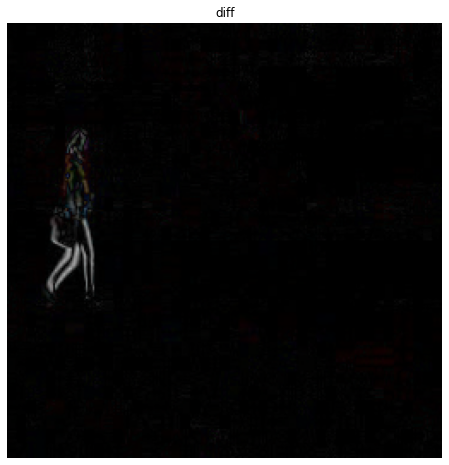

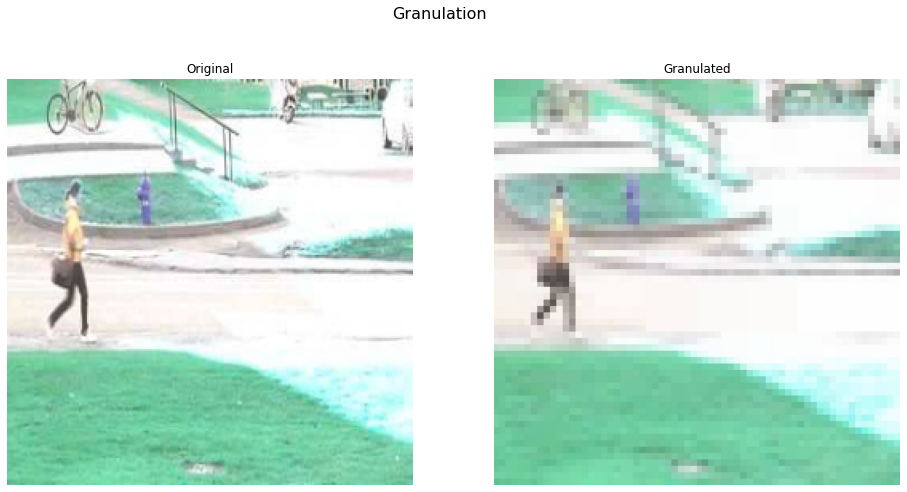

212.8776427552855 37.227298511685184
220
Threshold T: 220


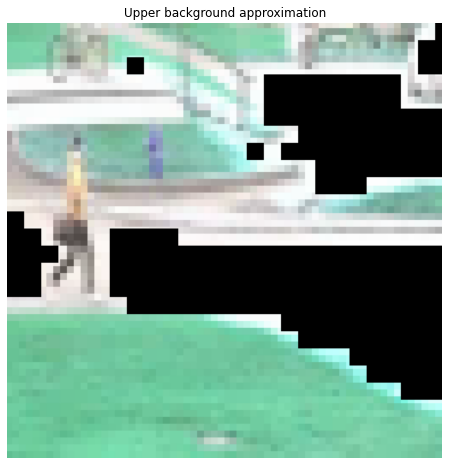

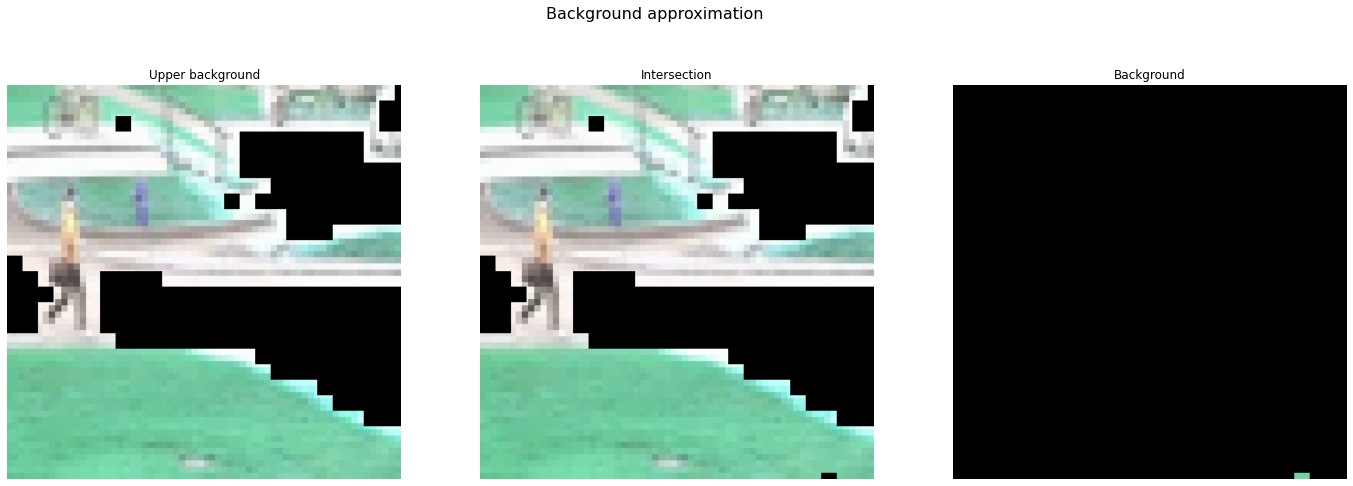

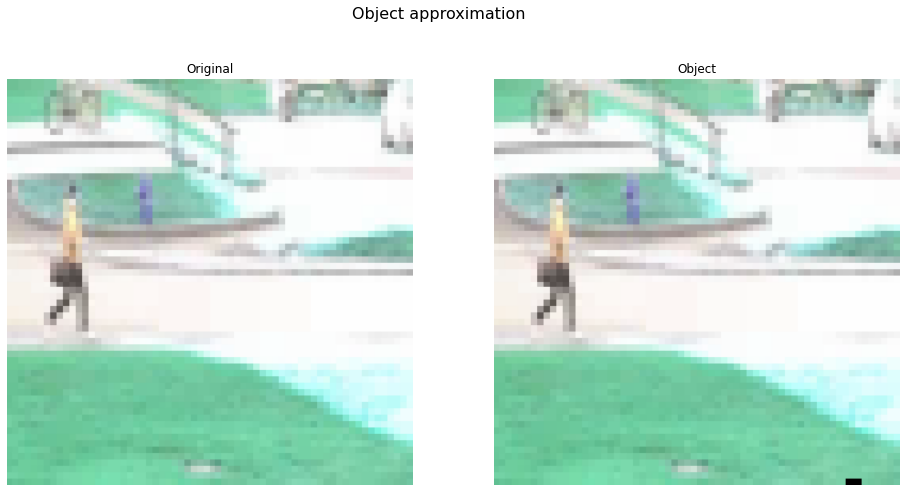

Processing frame: 332


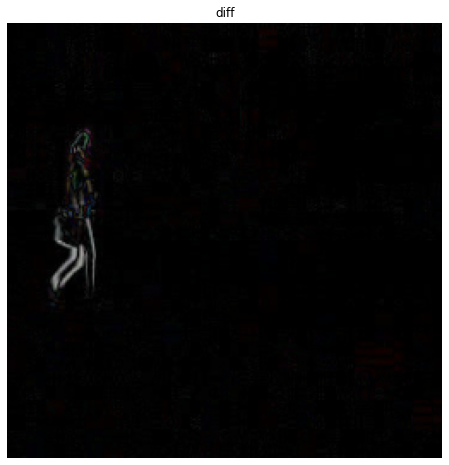

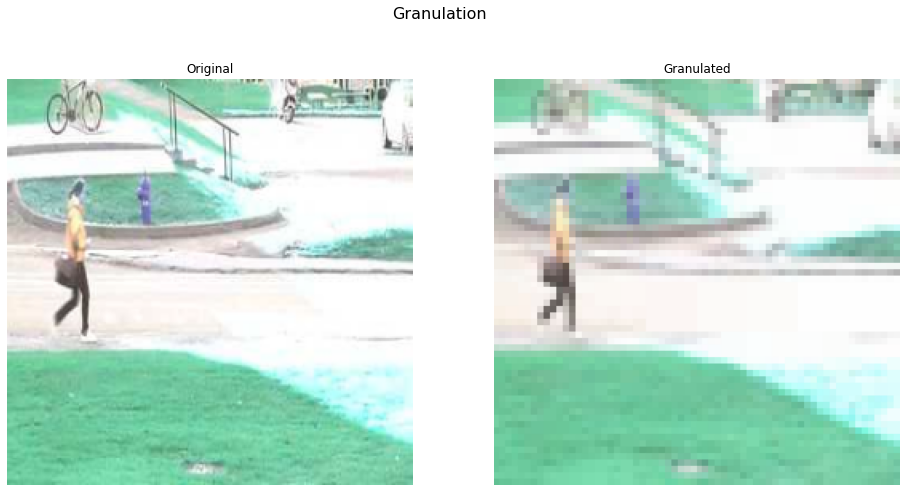

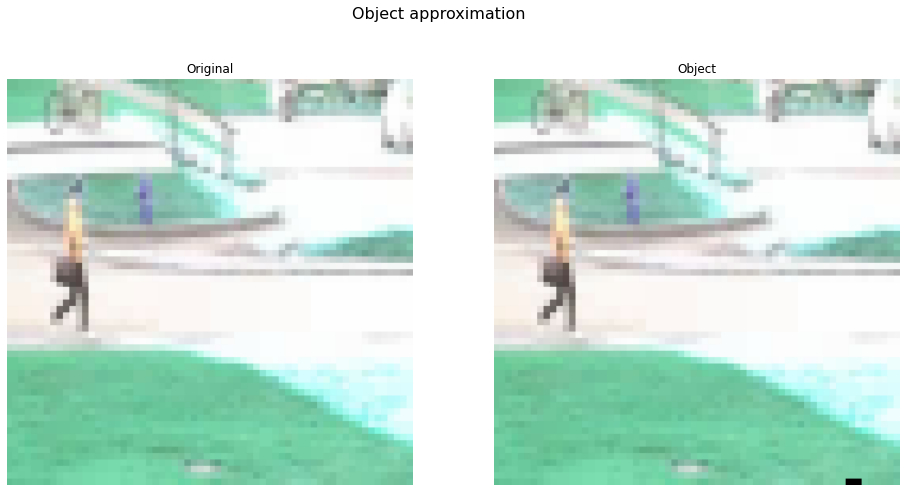

Processing frame: 333


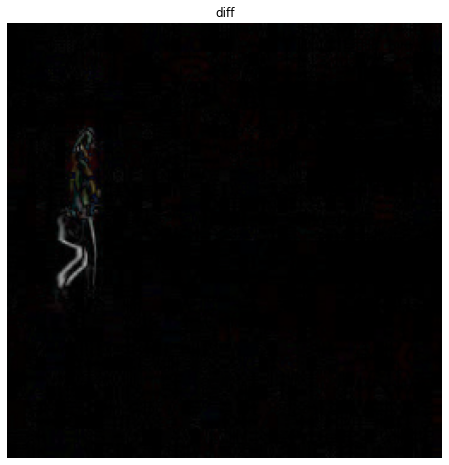

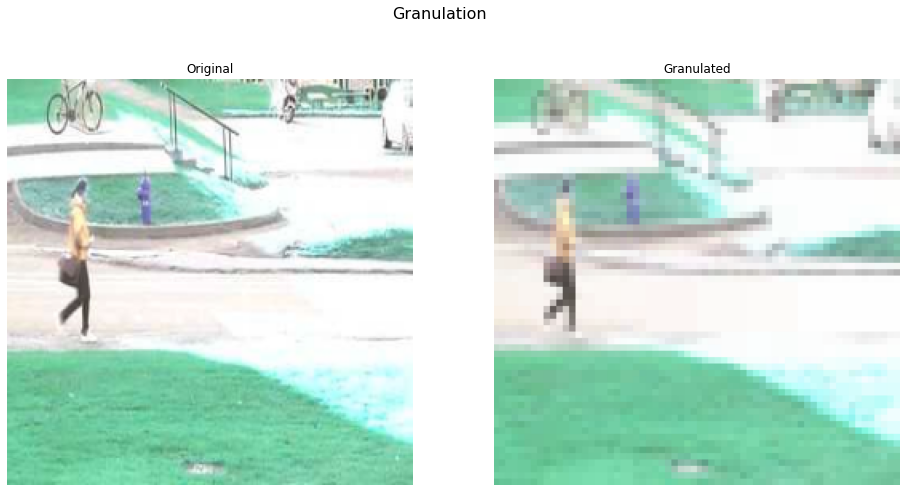

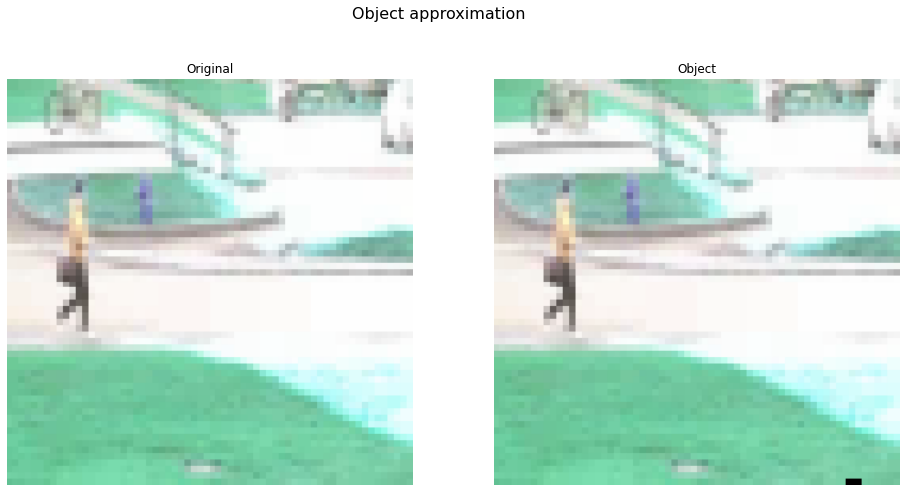

Processing frame: 334


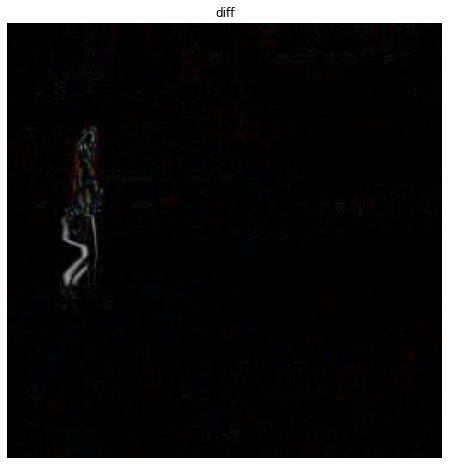

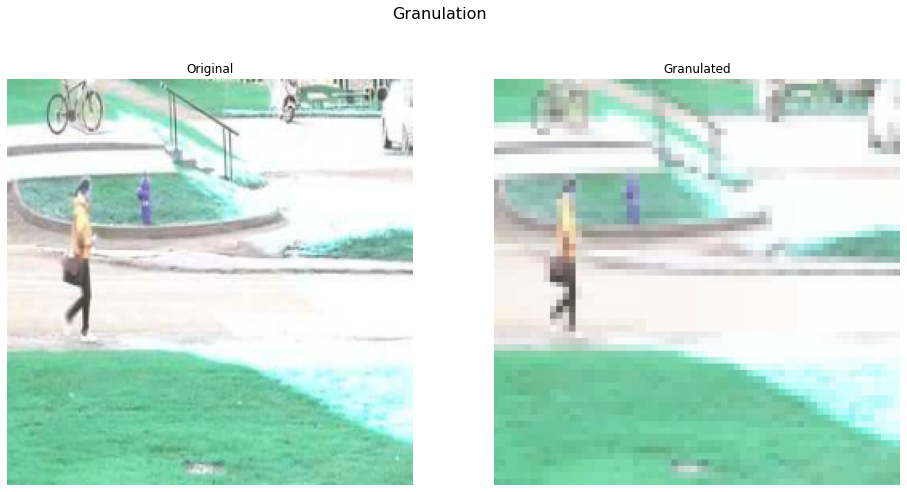

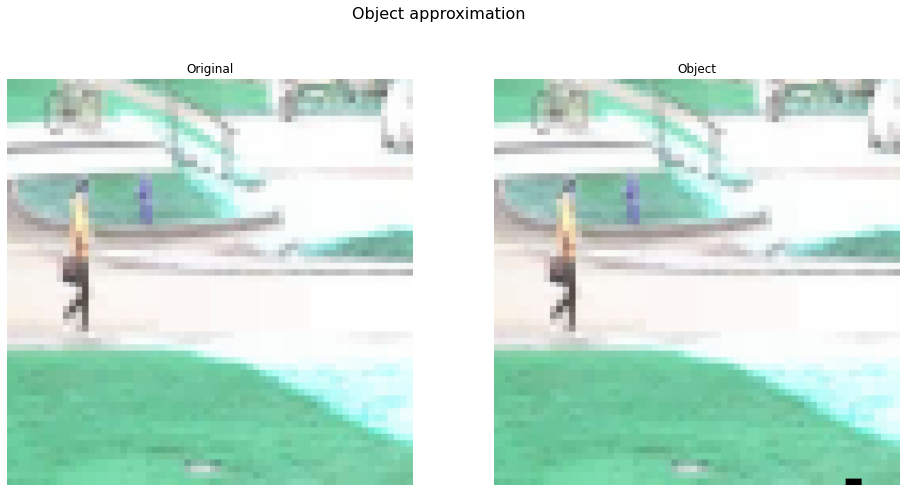

Processing frame: 335


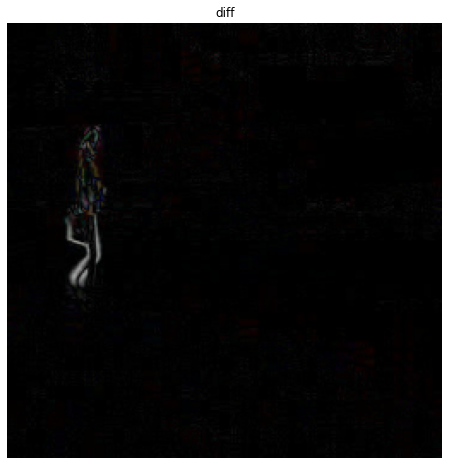

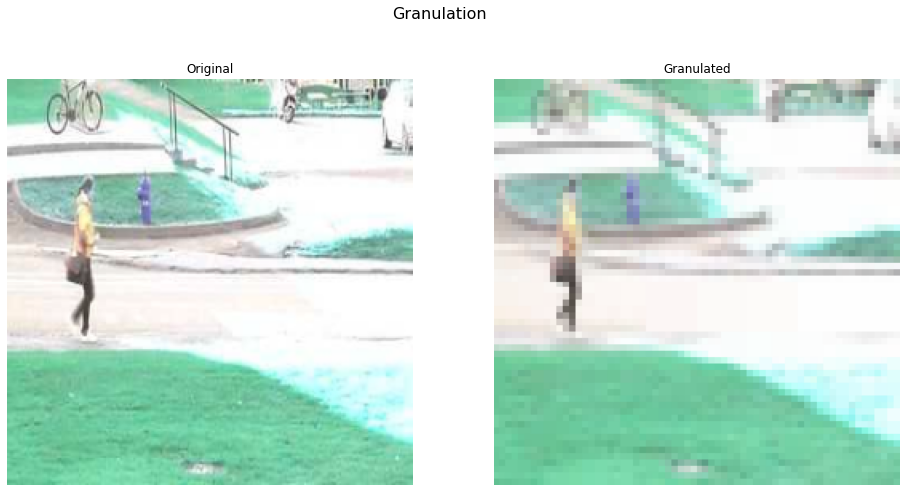

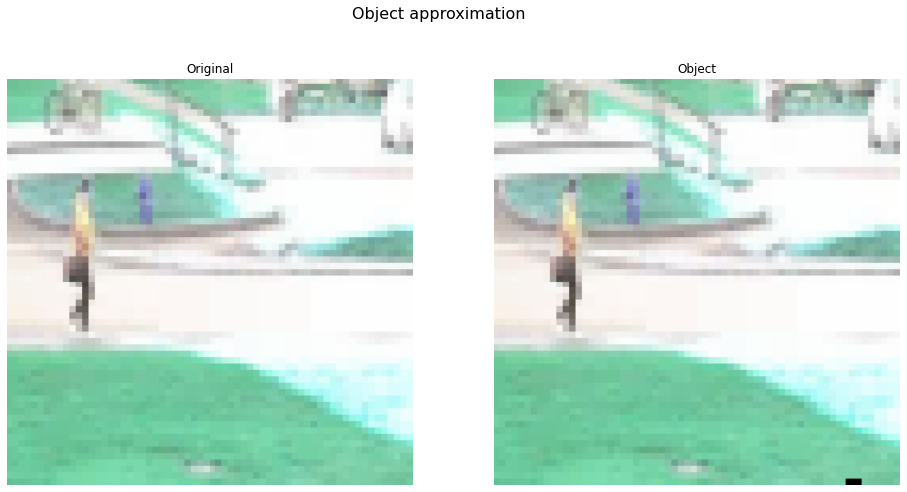

Processing frame: 336


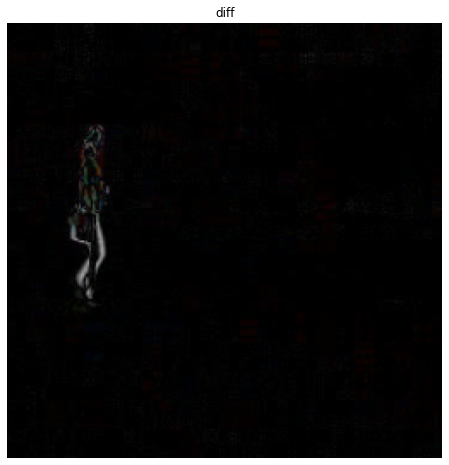

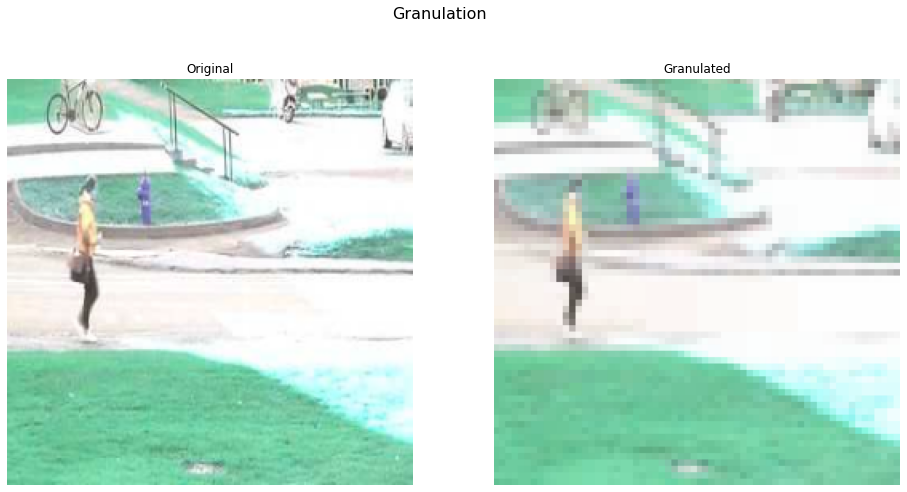

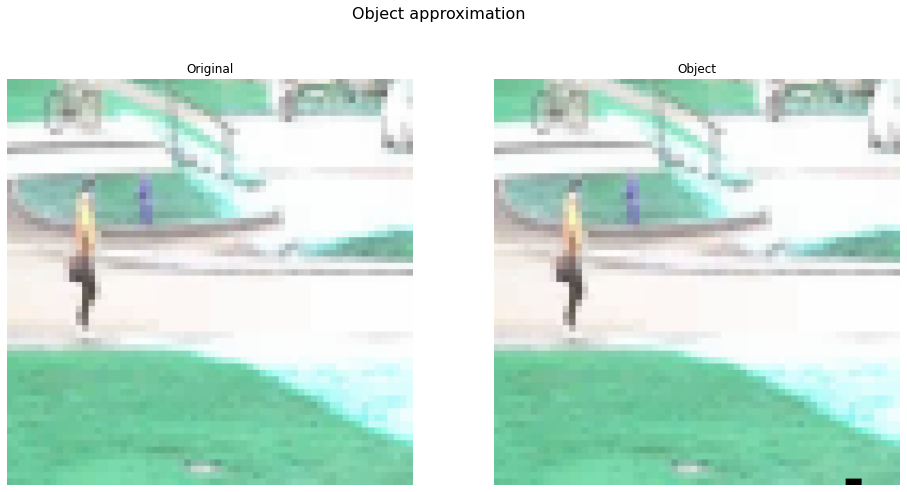

Processing frame: 337


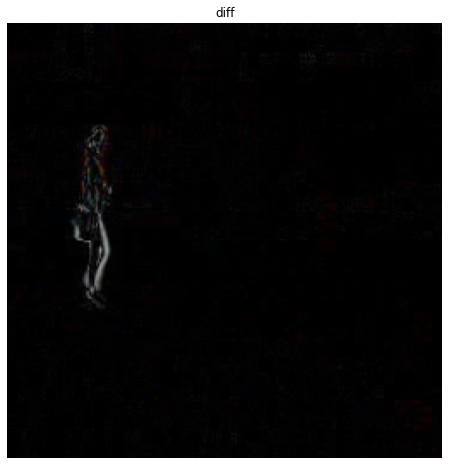

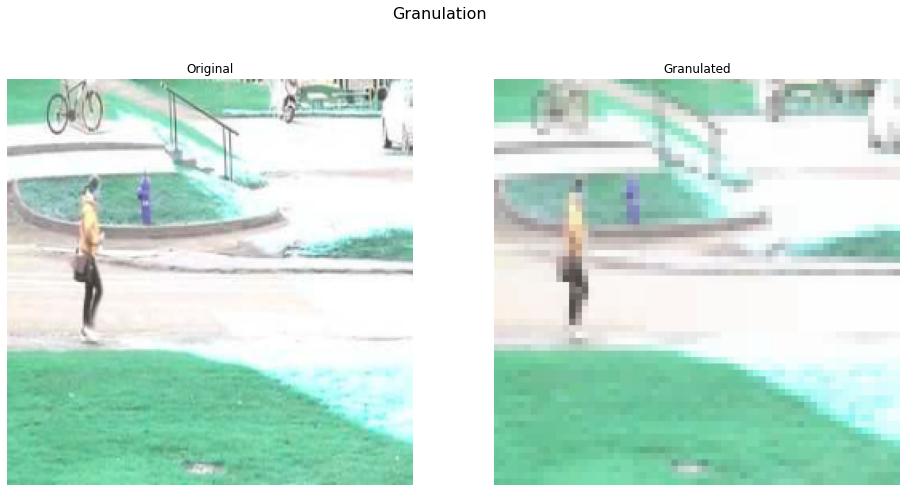

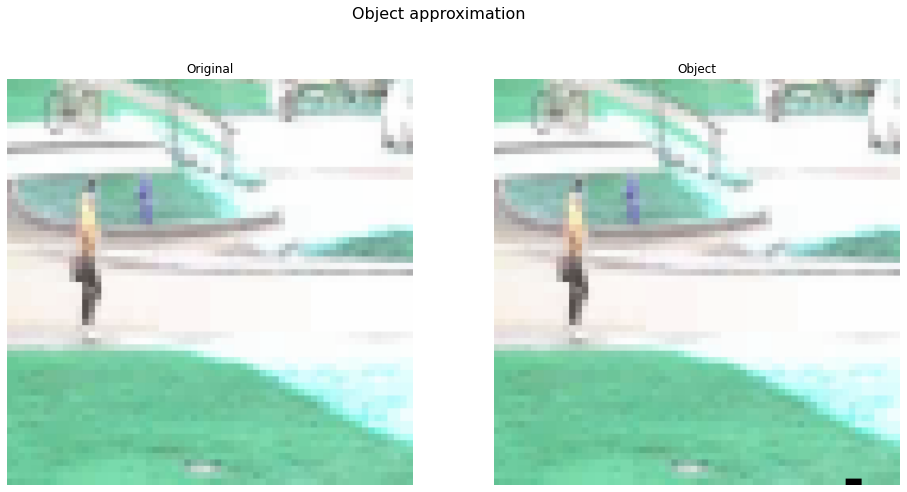

Processing frame: 338


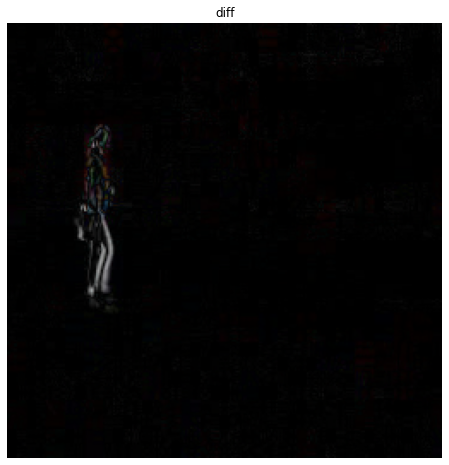

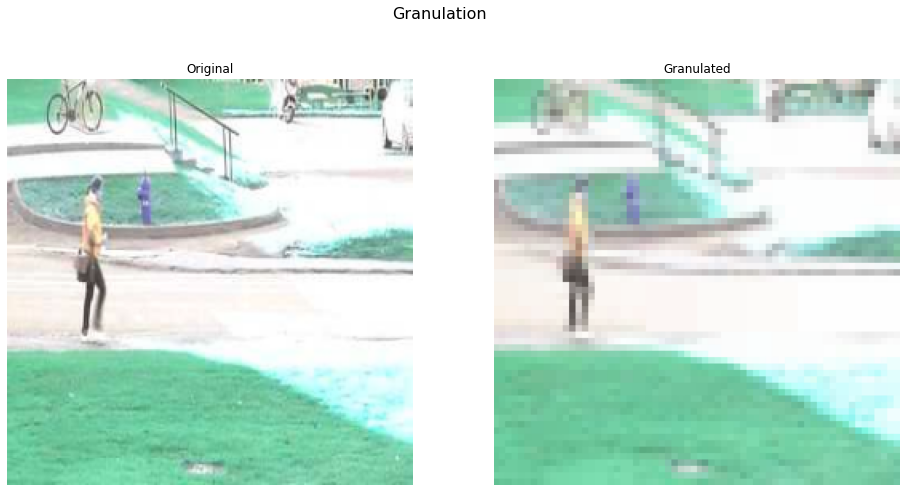

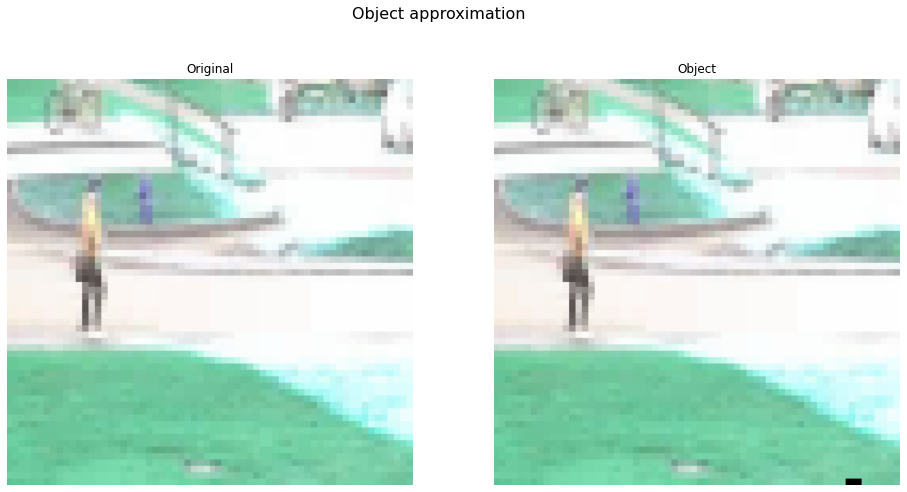

{'detection_classes': array([], dtype=int64), 'detection_boxes': array([], shape=(0, 4), dtype=float32), 'detection_scores': array([], dtype=float32), 'num_detections': 0}
[]


In [34]:
PATH = 'data/pedestrian'
I_prev = cv2.imread(f'{PATH}/input/in%06d.jpg' % roi_start)
granulation_mode_gt = True
is_visual = True
init_frame = True
first_frame = True
UB = None
BG = None

for i in range(roi_start+30, roi_start+39, 1):
    frame = cv2.imread(f'{PATH}/input/in%06d.jpg' % i)
    frame = cv2.resize(frame, (254, 254))
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    if init_frame:
        init_frame = False
        prev_frame = frame
        continue


    print('Processing frame:', i)
    
    d = calculate_differencing(prev_frame, frame, vis=is_visual)

    # TODO (2) add other method
    # if granulation_mode_gt:
    #     granulated_frame = granulation_gt(frame, visual=is_visual)
    #     # granulated_frame = cv2.cvtColor(granulated_frame, cv2.COLOR_BGR2GRAY)
    # else:
    # TODO (2) add other method
    if granulation_mode_gt:
        granulated_frame, granules = granulation_gt(frame, visual=is_visual)
    else:
        granulated_frame = granulation(frame, vis=is_visual)

    # TODO (2)

    if first_frame:
        if granulation_mode_gt:
            UB = upper_background_approximation(granulated_frame, frame_gray, granules, is_gtd=True, vis=is_visual)
        else:
            UB = upper_background_approximation(granulated_frame, frame_gray, vis=is_visual)

        BG = granulated_background_approximation(UB, d, granulated_frame, vis=is_visual)
        first_frame = False
    
    OB = granulated_object_approximation(granulated_frame, BG, vis=is_visual)

    # TODO (3)
    moving_objects = recognition_of_moving_objects(OB)
    # TODO (3)

    # TODO (4)
    track_objects(frame, moving_objects, is_visual=False)
    # TODO (4)

    prev_frame = frame

# TODO (1)
background_static_objects = recognition_of_static_background_objects(BG)
# vis_frame = cv2.resize(frame, (frame.shape[1]*4, frame.shape[0]*4))
# visualise_static_objects(vis_frame, background_static_objects)
print(background_static_objects)
static_objects = [[labels[object_class], score] for object_class, score in zip(background_static_objects['detection_classes'], background_static_objects['detection_scores'])]
print(static_objects)
# TODO (1)


#### Template for working with video

Processing frame: 1
Processing frame: 1
Processing frame: 1


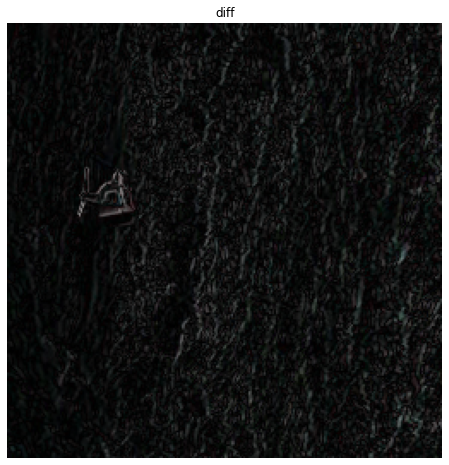

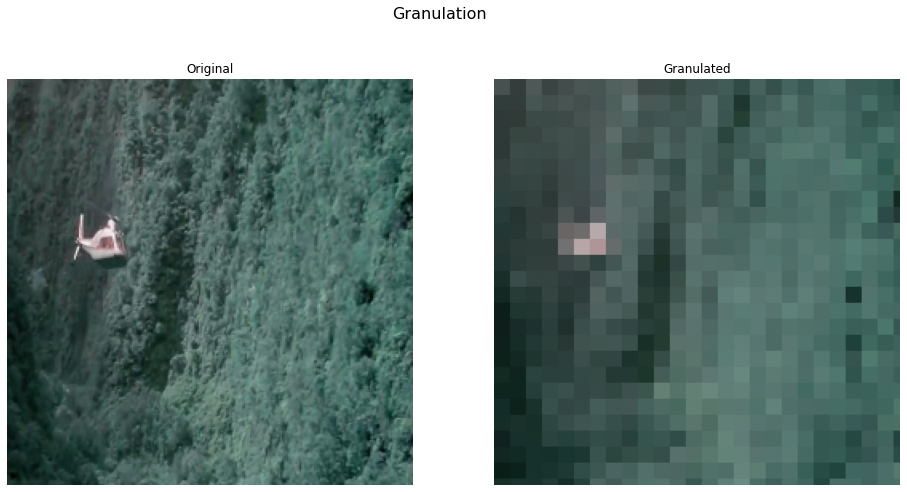

88.02125054250108 28.1531950428389
59
Threshold T: 59


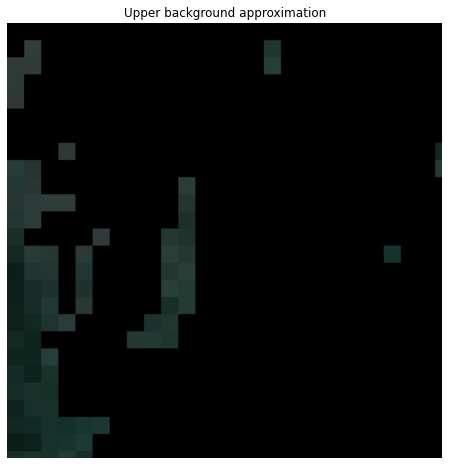

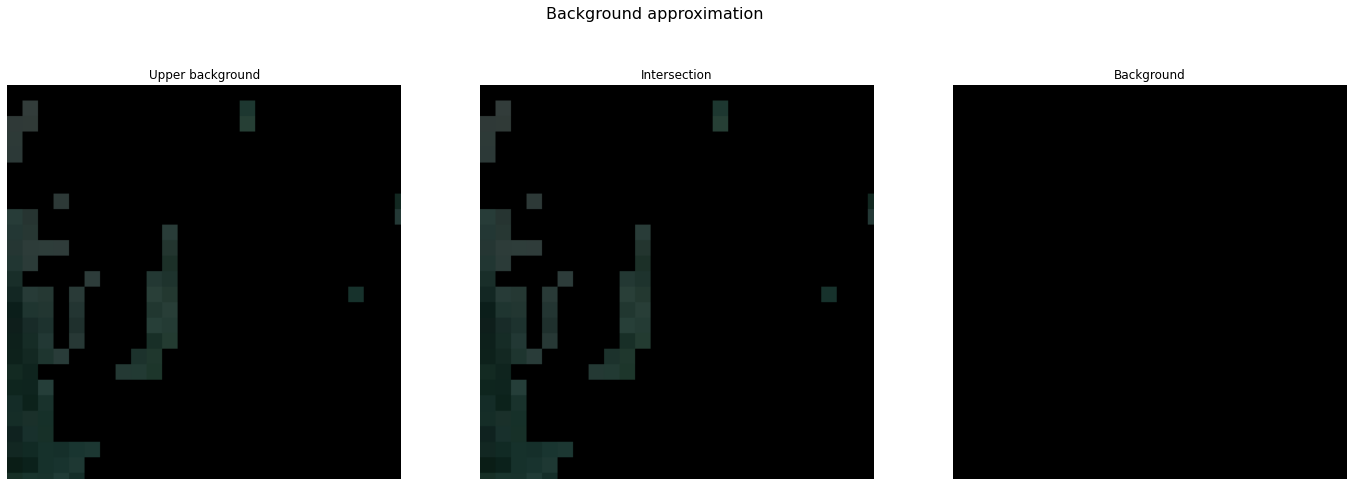

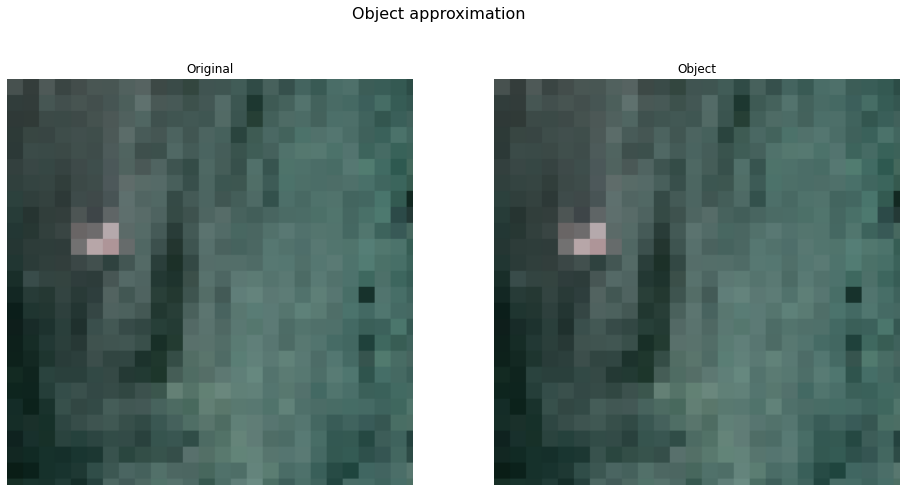

Processing frame: 2
Processing frame: 2


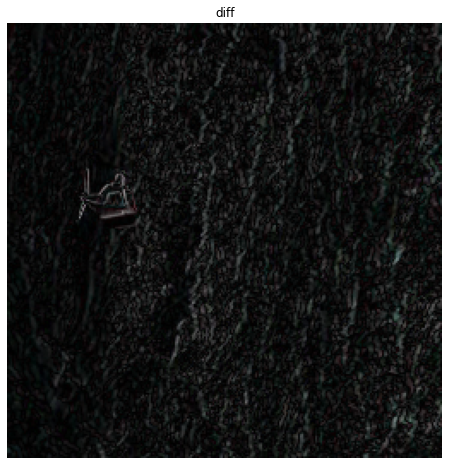

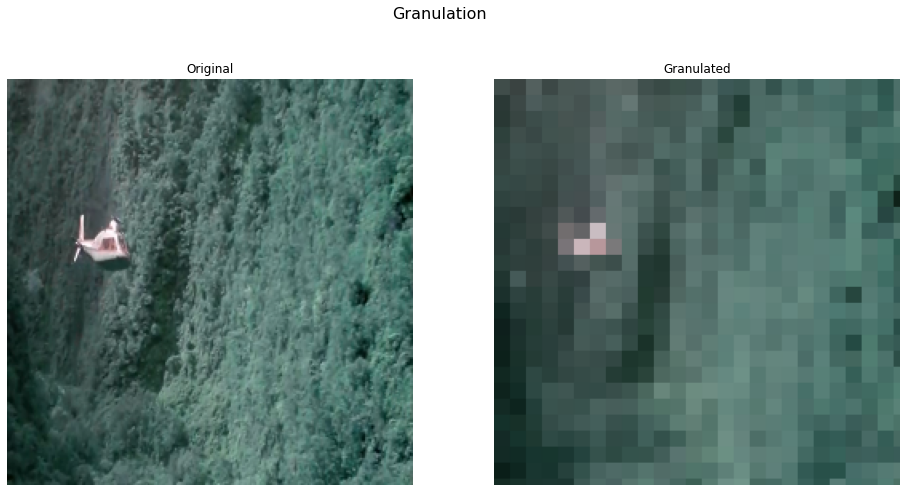

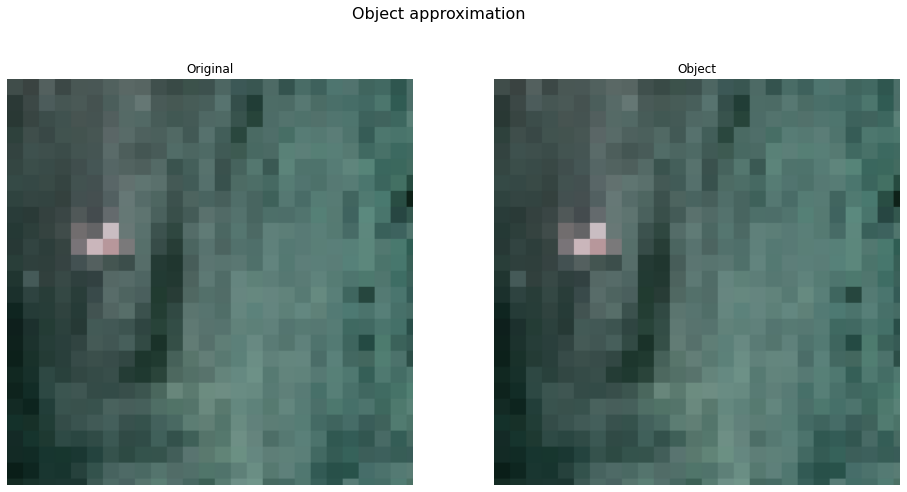

{'detection_classes': array([], dtype=int64), 'detection_boxes': array([], shape=(0, 4), dtype=float32), 'detection_scores': array([], dtype=float32), 'num_detections': 0}
[]


In [31]:
# Loading a video
cap = cv2.VideoCapture('data/video_jp_trim.mp4')
granulation_mode_gt = False
is_visual = True
init_frame = True
first_frame = True
UB = None
BG = None

# Processing the video frame by frame
i: int = 1
while cap.isOpened():
    ret, frame = cap.read()
    frame = cv2.resize(frame, (254, 254))
        
    if not ret:
        break

    print('Processing frame:', i)

        # frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    if init_frame:
        init_frame = False
        prev_frame = frame
        continue


    print('Processing frame:', i)
    
    d = calculate_differencing(prev_frame, frame, vis=is_visual)

    # TODO (2) add other method
    if granulation_mode_gt:
        granulated_frame = granulation_gt(frame, visual=is_visual)
    else:
        granulated_frame = granulation(frame, vis=is_visual)

    # TODO (2)

    if first_frame:
        UB = upper_background_approximation(granulated_frame, frame_gray, vis=is_visual)

        BG = granulated_background_approximation(UB, d, granulated_frame, vis=is_visual)
        first_frame = False
    
    OB = granulated_object_approximation(granulated_frame, BG, vis=is_visual)

    # TODO (3)
    moving_objects = recognition_of_moving_objects(OB)
    # TODO (3)

    # TODO (4)
    track_objects(frame, moving_objects, is_visual=False)
    # TODO (4)

    prev_frame = frame

    i += 1
    if i == 3:
        break
    
# TODO (1)
background_static_objects = recognition_of_static_background_objects(BG)
# vis_frame = cv2.resize(frame, (frame.shape[1]*4, frame.shape[0]*4))
# visualise_static_objects(vis_frame, background_static_objects)
print(background_static_objects)
static_objects = [[labels[object_class], score] for object_class, score in zip(background_static_objects['detection_classes'], background_static_objects['detection_scores'])]
print(static_objects)
# TODO (1)
# Zwolnienie zasobów
cap.release()
cv2.destroyAllWindows()